Python 3 implementation of plotFMpoints.m for NSIDC-0497
'MOA-derived Structural Feature Map of the Ronne Ice Shelf'
dataset. Converts the row-based point data into polylines.

In [1]:
import pandas as pd
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import shapely.geometry

In [2]:
#%% Import data into pandas
df = pd.read_csv(filepath_or_buffer='nsidc-0497/RonneFM_fractures.txt', sep=' ', header=None)
headers = ['Longitude', 'Latitude', 'GridX', 'GridY', 'SetNumber', 'GroupNumber']
df = df.rename(columns={i:v for i,v in enumerate(headers)})
df.head()

,Longitude,Latitude,GridX,GridY,SetNumber,GroupNumber
0,-41.001142,-78.030568,-856220.6166,984929.4948,1,1
1,-40.986828,-78.040385,-855267.5497,984329.7088,1,1
2,-40.984898,-78.050691,-854492.3002,983504.3880,1,1
3,-40.967540,-78.060454,-853491.5157,982953.8174,1,1
4,-40.939188,-78.074577,-851988.9482,982204.6734,1,1


In [3]:
#%% Get data into geopandas Geoseries format
sets = df.GroupNumber.unique()  #get list of group numbers e.g. [1,2,3,...,1169]
series = []
for s in sets:
    linecoords = [(x, y) for x, y in zip(df[df['GroupNumber']==s].GridX, df[df['GroupNumber']==s].GridY)]
    try:
        assert(len(linecoords) != 1)  #make sure that we have more than one point
    except AssertionError:
        print('Skipping group {0} as only one point! Cannot build line'.format(s))
        continue
    linestring = shapely.geometry.LineString(coordinates=linecoords)
    series.append(linestring)
assert(len(series) <= len(sets))

Skipping group 41 as only one point! Cannot build line


In [4]:
#%% Create GeoDataFrame out of GeoSeries
gs = gpd.GeoSeries(series)
gs.crs = {'init': 'epsg:3031'}
gdf = gpd.GeoDataFrame(pd.DataFrame(sets, columns=['index']), geometry=gs)
gdf.head()

,index,geometry
0,1,"LINESTRING (-856220.6166 984929.4948, -855267...."
1,2,"LINESTRING (-763651.1568 951407.388, -758504.2..."
2,3,"LINESTRING (-752504.9386 958004.3914, -755006...."
3,4,"LINESTRING (-759482.3983999999 959506.9589, -7..."
4,5,"LINESTRING (-773131.9687 953955.6758, -769727...."


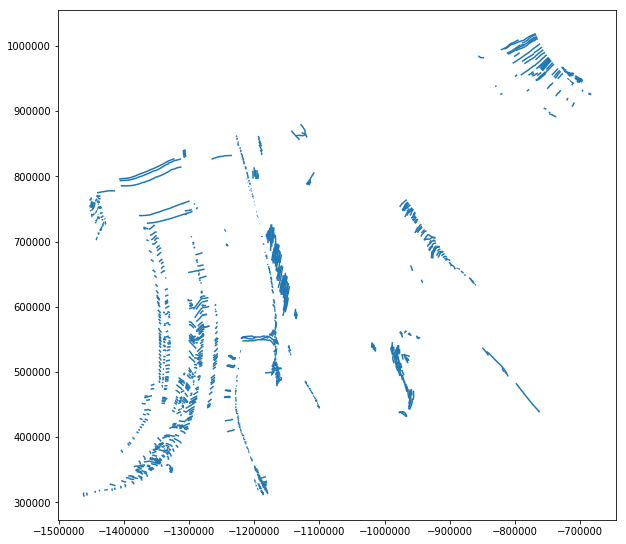

In [5]:
#%% Have a look at our Ronne ice shelf fractures using matplotlib
gdf.plot(figsize=(10,10))

In [6]:
#%% Export GeoDataFrame to GeoJson format!
assert('GeoJSON' in fiona.supported_drivers)
if not os.path.exists('model_data'):
    os.makedirs('model_data')
filename = 'model_data/RonneFM_fractures.geojson'
try:
    gdf.to_file(filename=filename, driver='GeoJSON')
except:
    pass
finally:
    print('Exported data to:', filename)

Exported data to: model_data/RonneFM_fractures.geojson
